In [1]:
# ============================================
# RESTART SPARK SESSION
# ============================================

# First, try to stop any existing session
try:
    spark.stop()
except:
    pass

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Create new session with MORE MEMORY
spark = SparkSession.builder \
    .appName("UltraMarathonCleaning") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "100") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.network.timeout", "600s") \
    .config("spark.sql.autoBroadcastJoinThreshold", "-1") \
    .getOrCreate()

print(f"Spark version: {spark.version}")
print("Spark session created successfully!")

Spark version: 4.1.1
Spark session created successfully!


In [ ]:
# ============================================
# COMPLETE CLEANING PIPELINE - RUN ALL AT ONCE
# ============================================

# Load data
df = spark.read.csv("C:/Users/youse/Dropbox/PC/Downloads/archive/TWO_CENTURIES_OF_UM_RACES.csv", header=True, inferSchema=True)
print(f"Loaded {df.count():,} rows")

# Clean column names
new_columns = [c.lower().replace(" ", "_").replace("/", "_").replace("-", "_") for c in df.columns]
df_clean = df.toDF(*new_columns)

# Apply all transformations
df_clean = (df_clean
    # Clean strings
    .withColumn("event_name", regexp_replace(col("event_name"), "^[\\ufeff\\u200b]+", ""))
    .withColumn("athlete_country", upper(trim(col("athlete_country"))))
    .withColumn("athlete_gender", upper(trim(col("athlete_gender"))))
    
    # Parse dates safely
    .withColumn("event_date_str", regexp_extract(col("event_dates"), r"(\d{2}\.\d{2}\.\d{4})", 1))
    .withColumn("event_start_date", try_to_date(col("event_date_str"), "dd.MM.yyyy"))
    
    # Parse distance
    .withColumn("distance_value",
                when(regexp_extract(col("event_distance_length"), r"(\d+\.?\d*)", 1) != "",
                     regexp_extract(col("event_distance_length"), r"(\d+\.?\d*)", 1).cast(DoubleType()))
                .otherwise(None))
    .withColumn("distance_unit",
                when(regexp_extract(col("event_distance_length"), r"\d+\.?\d*\s*([a-zA-Z]+)", 1) != "",
                     lower(regexp_extract(col("event_distance_length"), r"\d+\.?\d*\s*([a-zA-Z]+)", 1)))
                .otherwise(None))
    .withColumn("distance_km",
                when(col("distance_unit").isin("mi", "miles"), col("distance_value") * 1.60934)
                .when(col("distance_unit") == "km", col("distance_value"))
                .otherwise(None))
    
    # Parse performance
    .withColumn("perf_days",
                when(regexp_extract(col("athlete_performance"), r"(\d+)d", 1) != "",
                     regexp_extract(col("athlete_performance"), r"(\d+)d", 1).cast(IntegerType()))
                .otherwise(lit(0)))
    .withColumn("perf_time", regexp_extract(col("athlete_performance"), r"(\d{1,2}:\d{2}:\d{2})", 1))
    .withColumn("performance_seconds",
                when(col("perf_time") != "",
                     col("perf_days") * 86400 +
                     split(col("perf_time"), ":").getItem(0).cast(IntegerType()) * 3600 +
                     split(col("perf_time"), ":").getItem(1).cast(IntegerType()) * 60 +
                     split(col("perf_time"), ":").getItem(2).cast(IntegerType()))
                .otherwise(None))
    .withColumn("performance_hours", round(col("performance_seconds") / 3600, 2))
    
    # Clean birth year and age
    .withColumn("birth_year",
                when((col("athlete_year_of_birth") >= 1900) & (col("athlete_year_of_birth") <= 2005),
                     col("athlete_year_of_birth").cast(IntegerType()))
                .otherwise(None))
    .withColumn("athlete_age",
                when(col("birth_year").isNotNull(), col("year_of_event") - col("birth_year"))
                .otherwise(None))
    
    # Clean average speed
    .withColumn("avg_speed_kmh",
                when(col("athlete_average_speed").rlike(r"^\d+\.?\d*$"),
                     col("athlete_average_speed").cast(DoubleType()))
                .otherwise(None))
    .withColumn("avg_speed_kmh",
                when((col("avg_speed_kmh") > 0) & (col("avg_speed_kmh") < 25), col("avg_speed_kmh"))
                .otherwise(None))
)

# Filter invalid records
df_filtered = (df_clean
    .filter(col("year_of_event").between(1950, 2023))
    .filter((col("athlete_age").isNull()) | (col("athlete_age").between(16, 90)))
    .filter(col("event_number_of_finishers") > 0)
    .filter(col("performance_seconds").isNotNull())
    .filter(col("performance_seconds") > 0)
)

# Select final columns (reduces memory)
df_final = df_filtered.select(
    col("year_of_event"),
    col("event_start_date"),
    col("event_name"),
    col("event_distance_length").alias("distance_original"),
    col("distance_km"),
    col("distance_unit"),
    col("event_number_of_finishers"),
    col("athlete_id"),
    col("athlete_gender"),
    col("athlete_country"),
    col("birth_year"),
    col("athlete_age"),
    col("athlete_age_category"),
    col("athlete_club"),
    col("athlete_performance").alias("performance_original"),
    col("performance_seconds"),
    col("performance_hours"),
    col("avg_speed_kmh")
)
# Instead of df_final.write.parquet...

# 1. Convert to Pandas
pdf = df_final.toPandas()

# Change the name slightly
pdf.to_parquet("C:/Users/youse/Dropbox/PC/Downloads/usa_ultra_marathon50km_mil_data/ultra_marathon_clean_final.parquet") 

print("Saved successfully as 'ultra_marathon_clean_final.parquet'")
#### SAVE IMMEDIATELY - Don't try to count first!
#print("Saving data...")
#df_final.write.mode("overwrite").parquet("cleaned_ultra_marathon.parquet")
#print("Data saved successfully!")

Loaded 7,461,195 rows
Saved successfully as 'ultra_marathon_clean_final.parquet'


In [5]:
# ============================================
# READ SAVED DATA
# ============================================

df = spark.read.parquet("C:/Users/youse/Dropbox/PC/Downloads/usa_ultra_marathon50km_mil_data/ultra_marathon_clean_final.parquet")

print(f"Total rows: {df.count():,}")
print("\nSchema:")
df.printSchema()

print("\nSample data:")
df.show(5, truncate=False)

Total rows: 6,931,102

Schema:
root
 |-- year_of_event: integer (nullable = true)
 |-- event_start_date: date (nullable = true)
 |-- event_name: string (nullable = true)
 |-- distance_original: string (nullable = true)
 |-- distance_km: double (nullable = true)
 |-- distance_unit: string (nullable = true)
 |-- event_number_of_finishers: integer (nullable = true)
 |-- athlete_id: integer (nullable = true)
 |-- athlete_gender: string (nullable = true)
 |-- athlete_country: string (nullable = true)
 |-- birth_year: double (nullable = true)
 |-- athlete_age: double (nullable = true)
 |-- athlete_age_category: string (nullable = true)
 |-- athlete_club: string (nullable = true)
 |-- performance_original: string (nullable = true)
 |-- performance_seconds: integer (nullable = true)
 |-- performance_hours: double (nullable = true)
 |-- avg_speed_kmh: double (nullable = true)


Sample data:
+-------------+----------------+-------------------+-----------------+-----------+-------------+---------

In [8]:
# ============================================
# QUICK DATA QUALITY CHECK before dropping duplicates
# ============================================

df = spark.read.parquet("C:/Users/youse/Dropbox/PC/Downloads/usa_ultra_marathon50km_mil_data/ultra_marathon_clean_final.parquet")

print("=== DATA SUMMARY ===\n")

# Basic counts
print(f"Total records: {df.count():,}")

# Gender
print("\nGender distribution:")
df.groupBy("athlete_gender").count().show()

# Top countries
print("\nTop 10 countries:")
df.groupBy("athlete_country").count().orderBy(desc("count")).show(10)

# Distance types
print("\nTop 10 distances:")
df.groupBy("distance_original").count().orderBy(desc("count")).show(10)

# Year range
print("\nYear range:")
df.agg(min("year_of_event"), max("year_of_event")).show()

=== DATA SUMMARY ===

Total records: 6,931,102

Gender distribution:
+--------------+-------+
|athlete_gender|  count|
+--------------+-------+
|             X|     45|
|             F|1291316|
|             M|5639737|
|          NULL|      4|
+--------------+-------+


Top 10 countries:
+---------------+-------+
|athlete_country|  count|
+---------------+-------+
|            USA|1257103|
|            FRA|1112383|
|            RSA| 872077|
|            JPN| 586160|
|            GER| 390467|
|            GBR| 326419|
|            ITA| 309641|
|            ESP| 225911|
|            CHN| 214238|
|            AUS| 136272|
+---------------+-------+
only showing top 10 rows

Top 10 distances:
+-----------------+-------+
|distance_original|  count|
+-----------------+-------+
|             50km|1521852|
|            100km| 951373|
|             50mi| 351816|
|             56km| 333222|
|             87km| 211829|
|             89km| 187978|
|            100mi| 173831|
|             60km| 159

In [ ]:
# 1. Perform the deduplication in Spark (This is fine!)
df_dedup = df.dropDuplicates(["athlete_id", "event_name"])

# 2. THE FIX: Convert to Pandas explicitly to save
# We use toPandas() to bypass the Hadoop/Windows permission error
# 1. Convert to Pandas (if you haven't already)
pdf_dedup = df_dedup.toPandas()

# 2. Save with a BRAND NEW name to avoid the conflict
pdf_dedup.to_parquet("C:/Users/youse/Dropbox/PC/Downloads/usa_ultra_marathon50km_mil_data/ultra_marathon_clean_final_withoutduplicates.parquet")

print("Success! Saved as 'ultra_marathon_clean_final_withoutduplicates.parquet'")

print("Deduplication complete and saved!")

Success! Saved as 'ultra_marathon_clean_final_withoutduplicates.parquet'
Deduplication complete and saved!


In [9]:
# ============================================
# QUICK DATA QUALITY CHECK after dropping duplicates
# ============================================

df = spark.read.parquet("C:/Users/youse/Dropbox/PC/Downloads/usa_ultra_marathon50km_mil_data/ultra_marathon_clean_final_withoutduplicates.parquet")

print("=== DATA SUMMARY ===\n")

# Basic counts
print(f"Total records: {df.count():,}")

# Gender
print("\nGender distribution:")
df.groupBy("athlete_gender").count().show()

# Top countries
print("\nTop 10 countries:")
df.groupBy("athlete_country").count().orderBy(desc("count")).show(10)

# Distance types
print("\nTop 10 distances:")
df.groupBy("distance_original").count().orderBy(desc("count")).show(10)

# Year range
print("\nYear range:")
df.agg(min("year_of_event"), max("year_of_event")).show()

=== DATA SUMMARY ===

Total records: 4,886,881

Gender distribution:
+--------------+-------+
|athlete_gender|  count|
+--------------+-------+
|             X|     37|
|             F| 971693|
|          NULL|      4|
|             M|3915147|
+--------------+-------+


Top 10 countries:
+---------------+------+
|athlete_country| count|
+---------------+------+
|            USA|904152|
|            FRA|902899|
|            JPN|371824|
|            RSA|342965|
|            GBR|264632|
|            GER|243195|
|            ITA|214072|
|            CHN|195700|
|            ESP|184466|
|            TPE|107030|
+---------------+------+
only showing top 10 rows

Top 10 distances:
+-----------------+-------+
|distance_original|  count|
+-----------------+-------+
|             50km|1121097|
|            100km| 602994|
|             50mi| 245703|
|             56km| 138593|
|             45km| 128384|
|             60km| 127747|
|            100mi| 127625|
|             55km| 109249|
|        

## drop null values and X gender 


In [10]:
from pyspark.sql.functions import col

# Filter: Keep rows where athlete_gender is NOT equal to 'X'
df = df.filter(col("athlete_gender") != 'X')

# Verify the change: This should now only show 'M' and 'F' (or empty if nulls exist)
print("Row count after dropping X:", df.count())
df.select("athlete_gender").distinct().show()

Row count after dropping X: 4886840
+--------------+
|athlete_gender|
+--------------+
|             F|
|             M|
+--------------+



### count null values


In [11]:
from pyspark.sql.functions import col, sum as _sum

# 1. Define the columns you actually have (based on your previous steps)
actual_columns = [
    "athlete_gender", 
    "athlete_age", 
    "athlete_country", 
    "athlete_club", 
    "distance_km",
    "avg_speed_kmh"
]

# 2. Count nulls for these specific columns
df.select(
    [_sum(col(c).isNull().cast("int")).alias(c) for c in actual_columns]
).show()

+--------------+-----------+---------------+------------+-----------+-------------+
|athlete_gender|athlete_age|athlete_country|athlete_club|distance_km|avg_speed_kmh|
+--------------+-----------+---------------+------------+-----------+-------------+
|             0|     458116|              1|     2016688|       1137|       256368|
+--------------+-----------+---------------+------------+-----------+-------------+



In [12]:
# 1. Drop rows where critical performance data is missing
# (This removes the 1,445 missing distance and many of the missing speeds)
df_clean_final = df.dropna(subset=["distance_km", "avg_speed_kmh", "performance_seconds"])

In [16]:
# ============================================
# QUICK DATA QUALITY CHECK AGAIN
# ============================================



print("=== DATA SUMMARY ===\n")

# Basic counts
print(f"Total records after dropping nulls: {df_clean_final.count():,}")

# Gender
print("\nGender distribution:")
df_clean_final.groupBy("athlete_gender").count().show()

# Top countries
print("\nTop 10 countries:")
df_clean_final.groupBy("athlete_country").count().orderBy(desc("count")).show(10)

# Distance types
print("\nTop 10 distances:")
df_clean_final.groupBy("distance_original").count().orderBy(desc("count")).show(10)

# Year range
print("\nYear range:")
df_clean_final.agg(min("year_of_event"), max("year_of_event")).show()

=== DATA SUMMARY ===

Total records after dropping nulls: 4,630,426

Gender distribution:
+--------------+-------+
|athlete_gender|  count|
+--------------+-------+
|             F| 950336|
|             M|3680090|
+--------------+-------+


Top 10 countries:
+---------------+------+
|athlete_country| count|
+---------------+------+
|            FRA|870303|
|            USA|862896|
|            JPN|371142|
|            RSA|274258|
|            GBR|256812|
|            GER|199900|
|            ITA|195657|
|            CHN|195614|
|            ESP|183171|
|            TPE|107029|
+---------------+------+
only showing top 10 rows

Top 10 distances:
+-----------------+-------+
|distance_original|  count|
+-----------------+-------+
|             50km|1102295|
|            100km| 514072|
|             50mi| 224310|
|             45km| 125658|
|             60km| 125522|
|            100mi| 119471|
|             56km| 117537|
|             55km| 108540|
|             80km|  78736|
|         

In [21]:
df_clean_final.printSchema()
print(df_clean_final.show(5))

root
 |-- year_of_event: integer (nullable = true)
 |-- event_start_date: date (nullable = true)
 |-- event_name: string (nullable = true)
 |-- distance_original: string (nullable = true)
 |-- distance_km: double (nullable = true)
 |-- distance_unit: string (nullable = true)
 |-- event_number_of_finishers: integer (nullable = true)
 |-- athlete_id: integer (nullable = true)
 |-- athlete_gender: string (nullable = true)
 |-- athlete_country: string (nullable = true)
 |-- birth_year: double (nullable = true)
 |-- athlete_age: double (nullable = true)
 |-- athlete_age_category: string (nullable = true)
 |-- athlete_club: string (nullable = true)
 |-- performance_original: string (nullable = true)
 |-- performance_seconds: integer (nullable = true)
 |-- performance_hours: double (nullable = true)
 |-- avg_speed_kmh: double (nullable = true)

+-------------+----------------+--------------------+-----------------+-----------+-------------+-------------------------+----------+--------------+-

In [22]:
dff=df_clean_final.select("athlete_id", "event_name", "distance_km", "avg_speed_kmh", "athlete_age", "athlete_gender", "athlete_country", "year_of_event", "event_start_date", "performance_seconds", "athlete_club", "performance_hours","event_number_of_finishers")


### finally saving the full cleaned data

In [24]:
dff = dff.toPandas()
dff.to_parquet("C:/Users/youse/Dropbox/PC/Downloads/usa_ultra_marathon50km_mil_data/fourmillion_fully_transformed_data.parquet")

### EDA 

In [ ]:
import pandas as pd
# 1. Load your fresh data (if not already loaded)
dff = pd.read_parquet("C:/Users/youse/Dropbox/PC/Downloads/usa_ultra_marathon50km_mil_data/fourmillion_fully_transformed_data.parquet")


C:\Users\youse\AppData\Local\Temp\ipykernel_23564\2743310093.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dff, x='month', order=month_order, palette='viridis', ax=axes[1, 0])
C:\Users\youse\AppData\Local\Temp\ipykernel_23564\2743310093.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset_dist, x='dist_category', y='avg_speed_kmh', order=main_distances, palette='magma', ax=axes[1, 1])


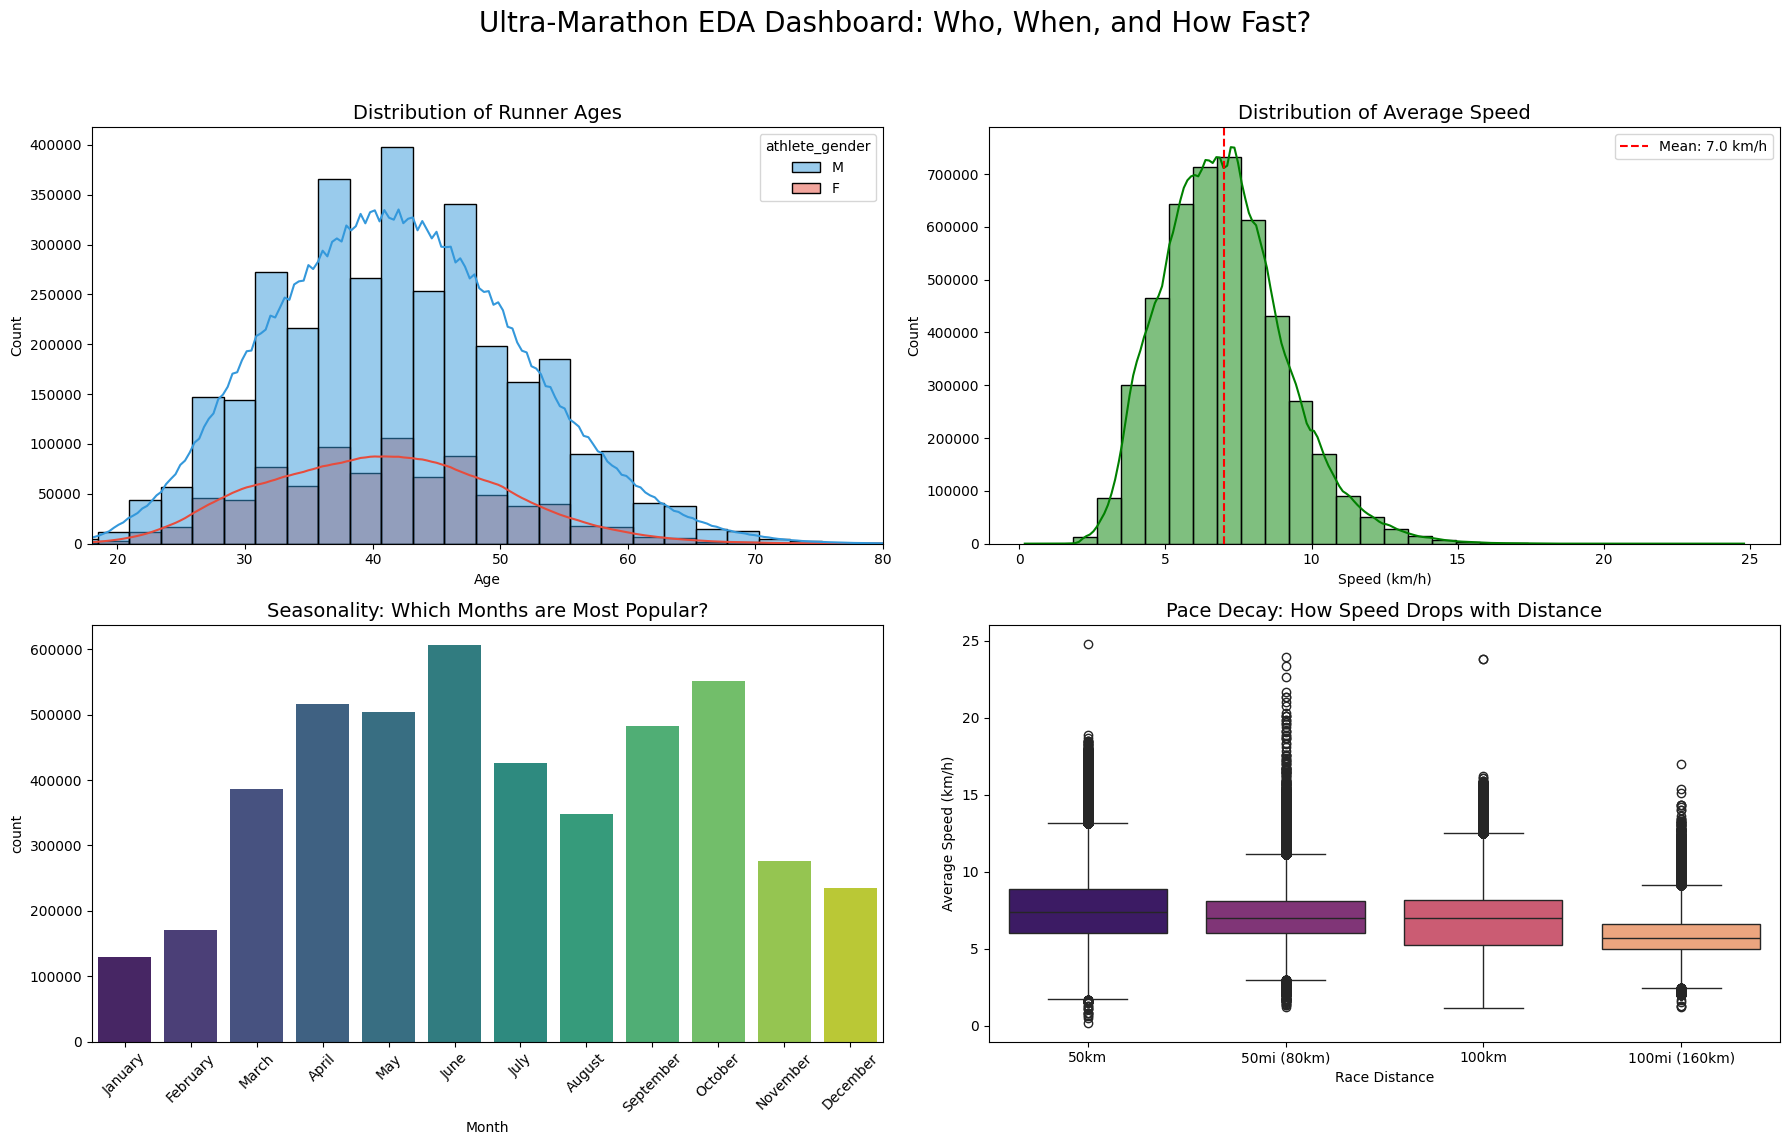

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure date format is correct for seasonality
dff['event_start_date'] = pd.to_datetime(dff['event_start_date'])
dff['month'] = dff['event_start_date'].dt.month_name()

# Define order for months and distances to keep charts logical
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Ultra-Marathon EDA Dashboard: Who, When, and How Fast?', fontsize=20)

# -------------------------------------------------------
# Plot 1: Age Distribution (Who is running?)
# -------------------------------------------------------
sns.histplot(data=dff, x='athlete_age', hue='athlete_gender', bins=30, kde=True, 
             palette={"M": "#3498db", "F": "#e74c3c"}, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Runner Ages', fontsize=14)
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_xlim(18, 80) # Focus on the main demographic

# -------------------------------------------------------
# Plot 2: Speed Distribution (How fast are they?)
# -------------------------------------------------------
sns.histplot(data=dff, x='avg_speed_kmh', bins=30, color='green', kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Average Speed', fontsize=14)
axes[0, 1].set_xlabel('Speed (km/h)')
axes[0, 1].axvline(dff['avg_speed_kmh'].mean(), color='red', linestyle='--', label=f"Mean: {dff['avg_speed_kmh'].mean():.1f} km/h")
axes[0, 1].legend()

# -------------------------------------------------------
# Plot 3: Seasonality (When do they run?)
# -------------------------------------------------------
sns.countplot(data=dff, x='month', order=month_order, palette='viridis', ax=axes[1, 0])
axes[1, 0].set_title('Seasonality: Which Months are Most Popular?', fontsize=14)
axes[1, 0].set_xlabel('Month')
axes[1, 0].tick_params(axis='x', rotation=45)

# -------------------------------------------------------
# Plot 4: Speed vs. Distance (The Pace Decay)
# -------------------------------------------------------
# Filter for main distances only to keep the boxplot clean
main_distances = ["50km", "50mi (80km)", "100km", "100mi (160km)"]
subset_dist = dff[dff['dist_category'].isin(main_distances)]

sns.boxplot(data=subset_dist, x='dist_category', y='avg_speed_kmh', order=main_distances, palette='magma', ax=axes[1, 1])
axes[1, 1].set_title('Pace Decay: How Speed Drops with Distance', fontsize=14)
axes[1, 1].set_xlabel('Race Distance')
axes[1, 1].set_ylabel('Average Speed (km/h)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

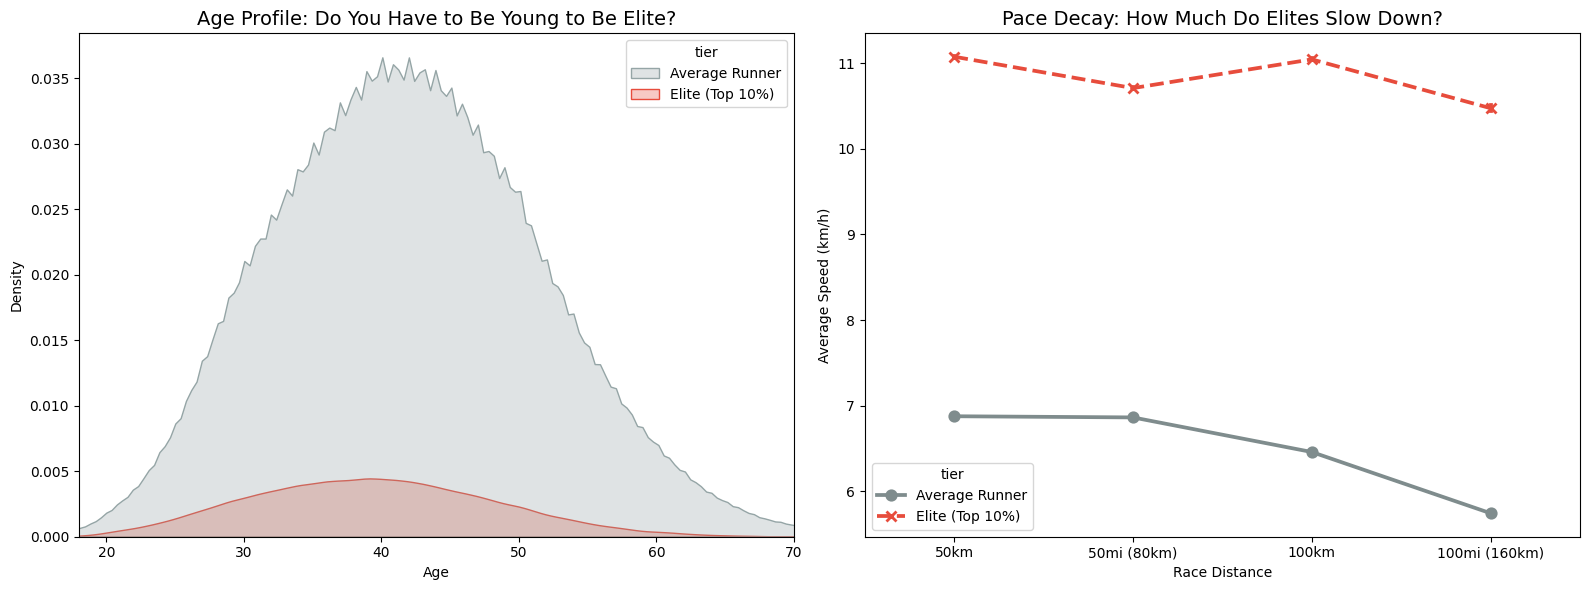

Elite Male Speed Threshold: > 9.82 km/h
Elite Female Speed Threshold: > 9.13 km/h


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Load Data
dff = pd.read_parquet("C:/Users/youse/Dropbox/PC/Downloads/usa_ultra_marathon50km_mil_data/fourmillion_fully_transformed_data.parquet")

# ---------------------------------------------------------
# FIX: Re-create the 'dist_category' column
# ---------------------------------------------------------
def bin_distance(dist):
    if 48 <= dist <= 52: return "50km"
    elif 78 <= dist <= 82: return "50mi (80km)"
    elif 98 <= dist <= 102: return "100km"
    elif 158 <= dist <= 165: return "100mi (160km)"
    else: return "Other"

dff['dist_category'] = dff['distance_km'].apply(bin_distance)
# ---------------------------------------------------------

# 2. Define "Elite" Thresholds (Top 10%)
male_threshold = dff[dff['athlete_gender'] == 'M']['avg_speed_kmh'].quantile(0.9)
female_threshold = dff[dff['athlete_gender'] == 'F']['avg_speed_kmh'].quantile(0.9)

# 3. Label the Data
def tag_elite(row):
    if row['athlete_gender'] == 'M' and row['avg_speed_kmh'] >= male_threshold:
        return "Elite (Top 10%)"
    elif row['athlete_gender'] == 'F' and row['avg_speed_kmh'] >= female_threshold:
        return "Elite (Top 10%)"
    else:
        return "Average Runner"

dff['tier'] = dff.apply(tag_elite, axis=1)

# 4. Create the Dashboard
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: Age Profile
sns.kdeplot(data=dff, x='athlete_age', hue='tier', fill=True, 
            palette={"Elite (Top 10%)": "#e74c3c", "Average Runner": "#95a5a6"}, 
            alpha=0.3, ax=axes[0])
axes[0].set_title('Age Profile: Do You Have to Be Young to Be Elite?', fontsize=14)
axes[0].set_xlabel('Age')
axes[0].set_xlim(18, 70)

# Chart 2: Pace Decay (Now 'dist_category' exists!)
main_distances = ["50km", "50mi (80km)", "100km", "100mi (160km)"]
subset_dist = dff[dff['dist_category'].isin(main_distances)]

sns.pointplot(data=subset_dist, x='dist_category', y='avg_speed_kmh', hue='tier', 
              order=main_distances, palette={"Elite (Top 10%)": "#e74c3c", "Average Runner": "#7f8c8d"},
              markers=["o", "x"], linestyles=["-", "--"], ax=axes[1])

axes[1].set_title('Pace Decay: How Much Do Elites Slow Down?', fontsize=14)
axes[1].set_ylabel('Average Speed (km/h)')
axes[1].set_xlabel('Race Distance')

plt.tight_layout()
plt.show()

# Print Stats
print(f"Elite Male Speed Threshold: > {male_threshold:.2f} km/h")
print(f"Elite Female Speed Threshold: > {female_threshold:.2f} km/h")

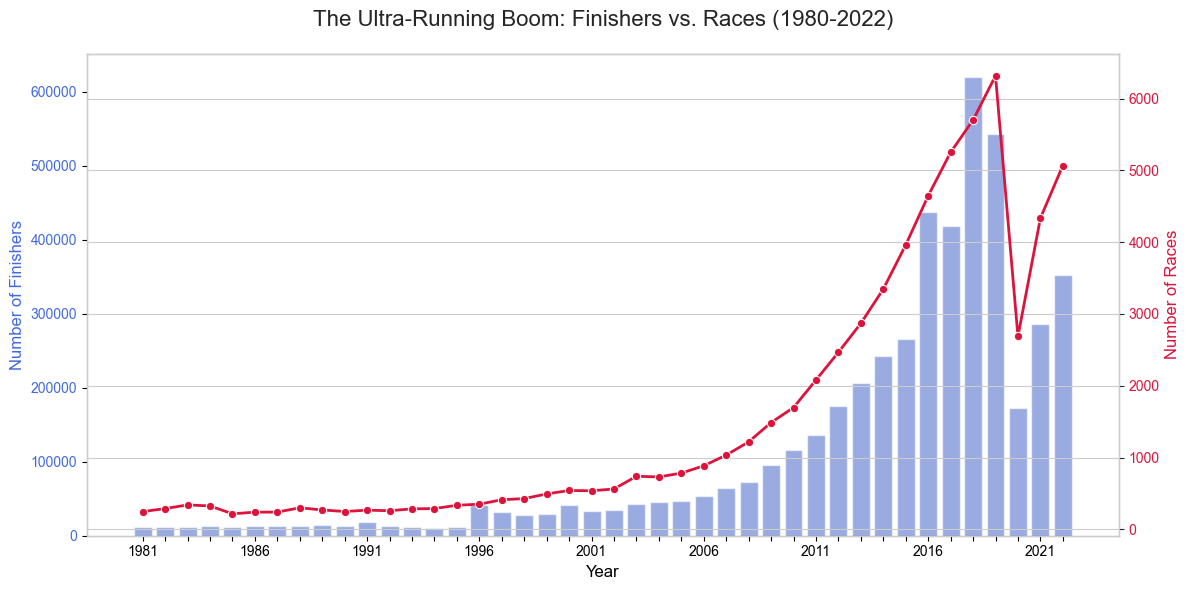

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Prepare the data (Assuming 'pdf_dedup' is your Pandas DataFrame)
# If you restarted your kernel, load it first:
# pdf_dedup = pd.read_parquet("ultra_marathon_clean_v2.parquet")

# Aggregate data by Year
growth_stats = pdf_dedup.groupby("year_of_event").agg(
    Total_Finishers=('athlete_id', 'count'),
    Unique_Events=('event_name', 'nunique')
).reset_index()

# Filter out 2023 if it's incomplete, or very old years with sparse data
growth_stats = growth_stats[growth_stats['year_of_event'] > 1980] 
growth_stats = growth_stats.sort_values("year_of_event")

# 2. Create the Dual-Axis Plot
fig, ax1 = plt.subplots(figsize=(12, 6))
sns.set_style("whitegrid")

# Plot 1: Bars for Total Finishers (Left Axis)
sns.barplot(data=growth_stats, x="year_of_event", y="Total_Finishers", 
            alpha=0.6, color="royalblue", ax=ax1)
ax1.set_ylabel("Number of Finishers", color="royalblue", fontsize=12)
ax1.tick_params(axis='y', labelcolor="royalblue")
ax1.set_xlabel("Year", fontsize=12)

# Make x-axis readable (show every 5th year)
for index, label in enumerate(ax1.get_xticklabels()):
    if index % 5 != 0:
        label.set_visible(False)

# Plot 2: Line for Number of Events (Right Axis)
ax2 = ax1.twinx()
sns.lineplot(data=growth_stats, x=ax1.get_xticks(), y="Unique_Events", 
             color="crimson", marker="o", linewidth=2, ax=ax2)
ax2.set_ylabel("Number of Races", color="crimson", fontsize=12)
ax2.tick_params(axis='y', labelcolor="crimson")

# Final Polish
plt.title("The Ultra-Running Boom: Finishers vs. Races (1980-2022)", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

### The "Peak Age" Curve: At what age do ultra-runners reach their fastest speeds?

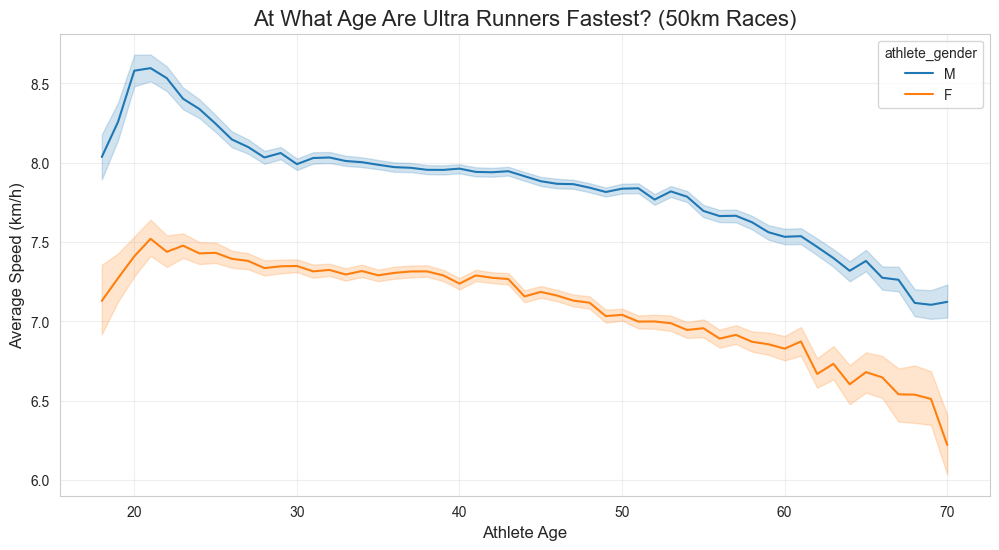

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load your fresh data (if not already loaded)
# df = pd.read_parquet("C:/Users/youse/Dropbox/PC/Downloads/usa_ultra_marathon50km_mil_data/fourmillion_fully_transformed_data.parquet")

# 2. Filter for clean age data (18-80) and standard race distances for fair comparison
# We focus on 50km races to keep the comparison standard
subset = dff[
    (dff['distance_km'] == 50) & 
    (dff['athlete_age'].between(18, 70)) &
    (dff['athlete_gender'].isin(['M', 'F']))
]

# 3. Create a smooth line plot (Speed vs Age)
plt.figure(figsize=(12, 6))
sns.lineplot(data=subset, x="athlete_age", y="avg_speed_kmh", hue="athlete_gender", palette=["#1f77b4", "#ff7f0e"])

plt.title("At What Age Are Ultra Runners Fastest? (50km Races)", fontsize=16)
plt.xlabel("Athlete Age", fontsize=12)
plt.ylabel("Average Speed (km/h)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

### Country Showdown (FRA vs USA): Who is actually faster on average?

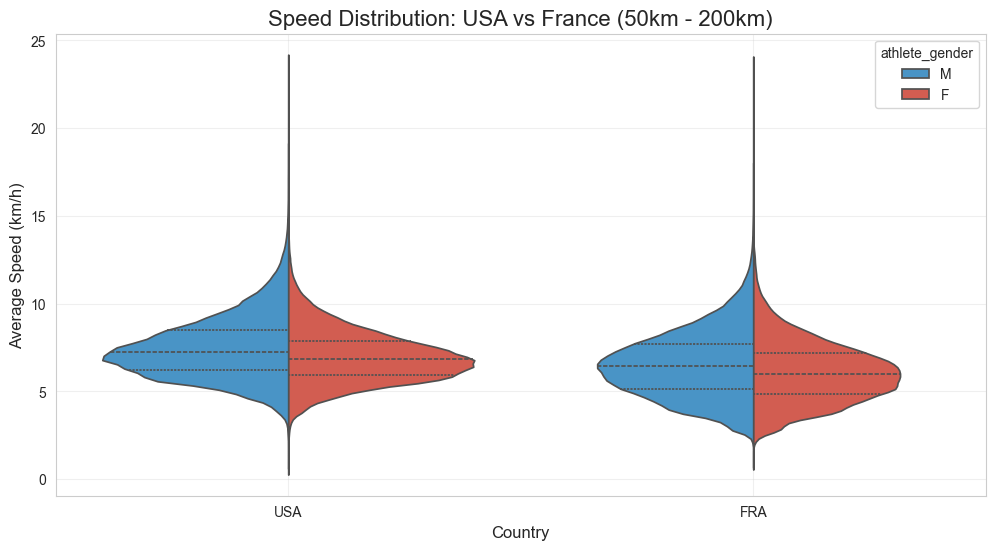

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Filter for only USA and France
usa_fra = dff[dff['athlete_country'].isin(['USA', 'FRA'])]

# 2. Filter for reasonable race distances to make it fair (50km - 200km)
# We exclude short sprints or multi-day runs that distort averages
usa_fra_subset = usa_fra[usa_fra['distance_km'].between(50, 200)]

# 3. Create the Violin Plot
plt.figure(figsize=(12, 6))
sns.violinplot(
    data=usa_fra_subset, 
    x="athlete_country", 
    y="avg_speed_kmh", 
    hue="athlete_gender", 
    split=True,            # Splits the violin to compare M/F side-by-side
    inner="quart",         # Draws lines for the median and quartiles
    palette={"M": "#3498db", "F": "#e74c3c"}
)

plt.title("Speed Distribution: USA vs France (50km - 200km)", fontsize=16)
plt.ylabel("Average Speed (km/h)", fontsize=12)
plt.xlabel("Country", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

C:\Users\youse\AppData\Local\Temp\ipykernel_30248\232106492.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usa_fra.loc[:, 'dist_category'] = usa_fra['distance_km'].apply(bin_distance)


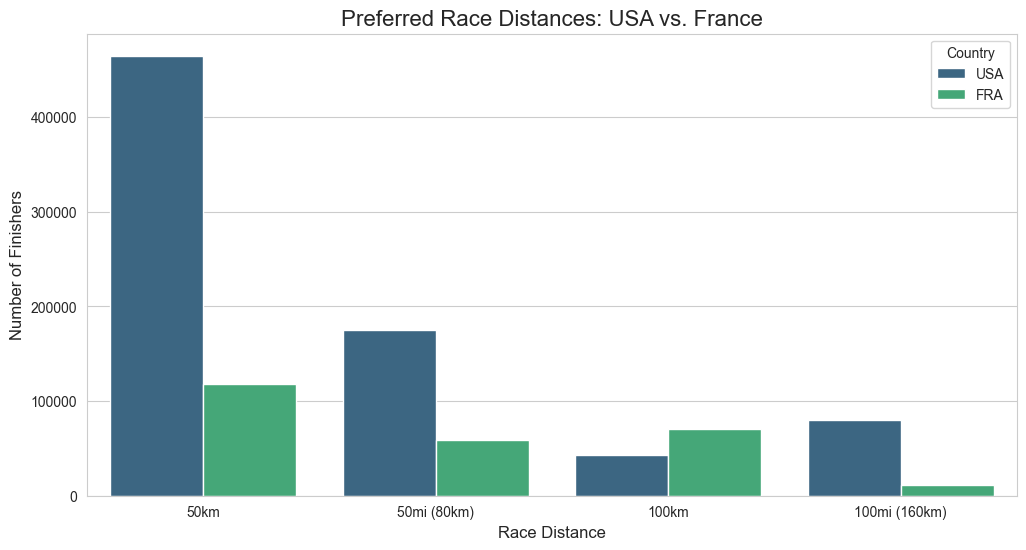

In [27]:
# Create a new column grouping distances for cleaner plotting
def bin_distance(dist):
    if 48 <= dist <= 52: return "50km"
    elif 78 <= dist <= 82: return "50mi (80km)"
    elif 98 <= dist <= 102: return "100km"
    elif 158 <= dist <= 165: return "100mi (160km)"
    else: return "Other"

# Apply the binning (using .loc to avoid SettingWithCopyWarning)
usa_fra.loc[:, 'dist_category'] = usa_fra['distance_km'].apply(bin_distance)

# Filter out "Other" to focus on the "Big 4" distances
viz_dist = usa_fra[usa_fra['dist_category'] != "Other"]

# Plot
plt.figure(figsize=(12, 6))
sns.countplot(
    data=viz_dist, 
    x="dist_category", 
    hue="athlete_country", 
    order=["50km", "50mi (80km)", "100km", "100mi (160km)"],
    palette="viridis"
)

plt.title("Preferred Race Distances: USA vs. France", fontsize=16)
plt.xlabel("Race Distance", fontsize=12)
plt.ylabel("Number of Finishers", fontsize=12)
plt.legend(title="Country")
plt.show()

## This is one of the most important questions in the sport. Historically, ultra-running was heavily male-dominated, but the trend has been shifting rapidly.

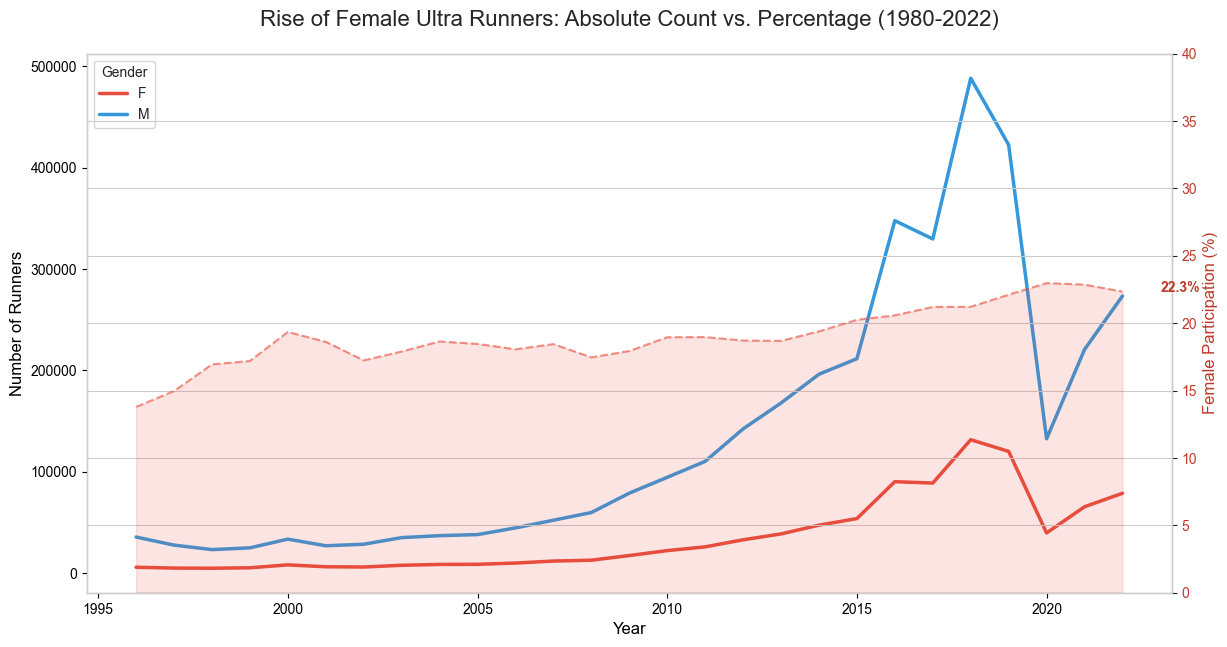

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# 1. Load your fresh data (if not already loaded)
dff = pd.read_parquet("C:/Users/youse/Dropbox/PC/Downloads/usa_ultra_marathon50km_mil_data/fourmillion_fully_transformed_data.parquet")
# 1. Prepare the data: Group by Year and Gender
# We filter for years > 1980 because data before that is very sparse/noisy
gender_growth = dff[dff['year_of_event'] > 1980].groupby(['year_of_event', 'athlete_gender']).size().reset_index(name='count')

# 2. Pivot the data to get separate columns for M and F
gender_pivot = gender_growth.pivot(index='year_of_event', columns='athlete_gender', values='count').fillna(0)
gender_pivot['Total'] = gender_pivot['M'] + gender_pivot['F']
gender_pivot['Female_Pct'] = (gender_pivot['F'] / gender_pivot['Total']) * 100

# 3. Create a Dual-Axis Chart
fig, ax1 = plt.subplots(figsize=(14, 7))
sns.set_style("whitegrid")

# Plot 1: Absolute Numbers (Line Chart)
# We plot Men and Women on the same axis to show the scale difference
sns.lineplot(data=gender_growth, x="year_of_event", y="count", hue="athlete_gender", 
             palette={"M": "#3498db", "F": "#e74c3c"}, linewidth=2.5, ax=ax1)

ax1.set_ylabel("Number of Runners", fontsize=12)
ax1.set_xlabel("Year", fontsize=12)
ax1.legend(title="Gender", loc="upper left")

# Plot 2: Female Percentage (Area Chart / Shadow) on Secondary Axis
ax2 = ax1.twinx()
ax2.fill_between(gender_pivot.index, gender_pivot['Female_Pct'], color="#e74c3c", alpha=0.15)
ax2.plot(gender_pivot.index, gender_pivot['Female_Pct'], color="#e74c3c", linestyle="--", linewidth=1.5, alpha=0.6)

ax2.set_ylabel("Female Participation (%)", color="#c0392b", fontsize=12)
ax2.tick_params(axis='y', labelcolor="#c0392b")
ax2.set_ylim(0, 40) # Set limit to 40% to make the trend visible (it rarely exceeds 30-35%)

# Add a text annotation for the latest value
latest_year = gender_pivot.index.max()
latest_pct = gender_pivot.loc[latest_year, 'Female_Pct']
ax2.text(latest_year+1, latest_pct, f"{latest_pct:.1f}%", color="#c0392b", fontweight="bold")

plt.title("Rise of Female Ultra Runners: Absolute Count vs. Percentage (1980-2022)", fontsize=16, pad=20)
plt.show()

C:\Users\youse\AppData\Local\Temp\ipykernel_23564\1575963364.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dist_pivot.index, y=dist_pivot['Female_Pct'], palette="magma")


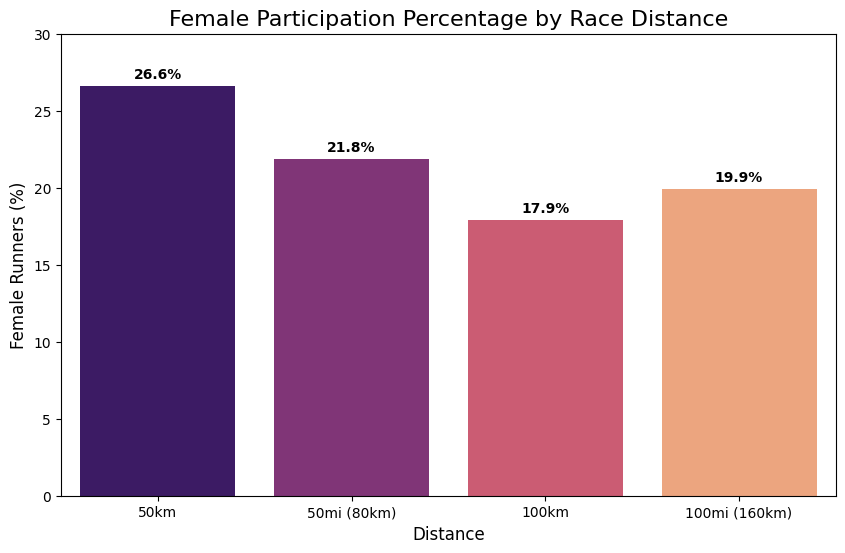

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# 1. Load your fresh data (if not already loaded)
dff = pd.read_parquet("C:/Users/youse/Dropbox/PC/Downloads/usa_ultra_marathon50km_mil_data/fourmillion_fully_transformed_data.parquet")

# 1. Create the 'dist_category' column if you haven't already
def bin_distance(dist):
    if 48 <= dist <= 52: return "50km"
    elif 78 <= dist <= 82: return "50mi (80km)"
    elif 98 <= dist <= 102: return "100km"
    elif 158 <= dist <= 165: return "100mi (160km)"
    else: return "Other"

dff['dist_category'] = dff['distance_km'].apply(bin_distance)

# 2. Filter for the main distances
dist_gender = dff[dff['dist_category'] != "Other"].groupby(['dist_category', 'athlete_gender']).size().reset_index(name='count')

# 3. Calculate Percentage for each distance
dist_pivot = dist_gender.pivot(index='dist_category', columns='athlete_gender', values='count').fillna(0)
dist_pivot['Total'] = dist_pivot['M'] + dist_pivot['F']
dist_pivot['Female_Pct'] = (dist_pivot['F'] / dist_pivot['Total']) * 100
dist_pivot = dist_pivot.reindex(["50km", "50mi (80km)", "100km", "100mi (160km)"])

# 4. Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=dist_pivot.index, y=dist_pivot['Female_Pct'], palette="magma")

plt.title("Female Participation Percentage by Race Distance", fontsize=16)
plt.ylabel("Female Runners (%)", fontsize=12)
plt.xlabel("Distance", fontsize=12)
plt.ylim(0, 30)

# Add labels on top of bars
for index, value in enumerate(dist_pivot['Female_Pct']):
    plt.text(index, value + 0.5, f"{value:.1f}%", ha='center', color="black", fontweight="bold")

plt.show()

## prepare for bi

In [4]:
import pandas as pd

# 1. Load the data
dff = pd.read_parquet("C:/Users/youse/Dropbox/PC/Downloads/usa_ultra_marathon50km_mil_data/fourmillion_fully_transformed_data.parquet")

# ---------------------------------------------------------
# PRE-PROCESSING: Ensure date columns exist for seasonality
# ---------------------------------------------------------
dff['event_start_date'] = pd.to_datetime(dff['event_start_date'])
dff['race_month'] = dff['event_start_date'].dt.month_name()

# ---------------------------------------------------------
# 1. YEARLY AGGREGATION
# ---------------------------------------------------------
df_yearly_agg = dff.groupby(['year_of_event', 'athlete_gender', 'distance_km']).agg(
    total_finishers=('athlete_id', 'count'),
    total_races=('event_name', 'nunique'),
    avg_speed=('avg_speed_kmh', 'mean'),
    avg_age=('athlete_age', 'mean')
).reset_index()

# ---------------------------------------------------------
# 2. COUNTRY AGGREGATION
# ---------------------------------------------------------
df_country_agg = dff.groupby(['athlete_country', 'year_of_event']).agg(
    finishers_by_country=('athlete_id', 'count')
).reset_index()

# ---------------------------------------------------------
# 3. MONTHLY SEASONALITY
# ---------------------------------------------------------
df_monthly_agg = dff.groupby(['race_month', 'distance_km']).agg(
    race_count=('athlete_id', 'count')
).reset_index()

# ---------------------------------------------------------
# CHECK RESULTS
# ---------------------------------------------------------
print("Yearly Aggregation Sample:")
print(df_yearly_agg.head())

print("\nCountry Aggregation Sample:")
print(df_country_agg.head())

Yearly Aggregation Sample:
   year_of_event athlete_gender  distance_km  total_finishers  total_races  \
0           1996              F     45.00000               12            1   
1           1996              F     45.06152               41            1   
2           1996              F     46.00000                1            1   
3           1996              F     46.60000               37            1   
4           1996              F     47.20000                5            1   

   avg_speed    avg_age  
0   6.964167  40.916667  
1   6.824317  42.878049  
2  12.042000  46.000000  
3   7.898270  40.135135  
4   7.944200  45.200000  

Country Aggregation Sample:
  athlete_country  year_of_event  finishers_by_country
0             AFG           2015                     3
1             AFG           2016                     3
2             AFG           2017                     3
3             AFG           2018                     5
4             AFG           2019            

In [7]:
import pandas as pd
import numpy as np

# 1. Create a copy to avoid SettingWithCopy warnings
df_optimized = dff.copy()

# 2. Optimize Numeric Types (Downcasting)
# 'int32' handles IDs up to 2 billion (safe)
df_optimized['athlete_id'] = df_optimized['athlete_id'].astype('int32')

# 'int16' handles years up to 32,767 (perfect for years)
df_optimized['year_of_event'] = df_optimized['year_of_event'].astype('int16')

# 'int8' handles ages up to 127 (perfect for age)
# NOTE: We use fillna(0) just in case there are nulls, as int8 cannot hold NaNs
df_optimized['athlete_age'] = df_optimized['athlete_age'].fillna(0).astype('int8')

# 'float32' cuts memory in half compared to float64, while keeping decimal precision
df_optimized['distance_km'] = df_optimized['distance_km'].astype('float32')
df_optimized['avg_speed_kmh'] = df_optimized['avg_speed_kmh'].astype('float32')

# 'int32' is sufficient for seconds (handles up to ~68 years of seconds)
df_optimized['performance_seconds'] = df_optimized['performance_seconds'].astype('int32')

# 3. Optimize String Types (The Big Memory Saver)
# Using 'category' for columns with few unique values (Gender, Country) saves massive RAM
df_optimized['athlete_gender'] = df_optimized['athlete_gender'].astype('category')
df_optimized['athlete_country'] = df_optimized['athlete_country'].astype('category')

# 4. Select Columns (This implicitly drops the others)
cols_to_keep = [
    'athlete_id', 'year_of_event', 'athlete_age', 'distance_km',
    'avg_speed_kmh', 'athlete_gender', 'athlete_country',
    'event_name', 'performance_seconds'
]

df_final = df_optimized[cols_to_keep]

# 5. Verify the Memory Savings
print(df_final.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4630426 entries, 0 to 4630425
Data columns (total 9 columns):
 #   Column               Dtype   
---  ------               -----   
 0   athlete_id           int32   
 1   year_of_event        int16   
 2   athlete_age          int8    
 3   distance_km          float32 
 4   avg_speed_kmh        float32 
 5   athlete_gender       category
 6   athlete_country      category
 7   event_name           object  
 8   performance_seconds  int32   
dtypes: category(2), float32(2), int16(1), int32(2), int8(1), object(1)
memory usage: 132.5+ MB
None


In [8]:
# ==========================================
# 1. DIM: Athletes
# ==========================================
# We drop duplicates to get a unique list of athletes
dim_athletes = dff[['athlete_id', 'athlete_gender', 'athlete_country']].drop_duplicates()

# ==========================================
# 2. DIM: Events
# ==========================================
# NOTE: I removed 'athlete_country' from here because an event (like UTMB) 
# has runners from many countries. Including it would duplicate the event rows.
dim_events = dff[['event_name', 'distance_km']].drop_duplicates()

# ==========================================
# 3. DIM: Date
# ==========================================
dim_date = dff[['year_of_event', 'event_start_date']].drop_duplicates()

# ==========================================
# 4. FACT: Race Results
# ==========================================
# The Fact table keeps all rows (every performance)
fact_races = dff[[
    'athlete_id', 
    'event_name', 
    'year_of_event', 
    'event_start_date',  # Added this so you can link to dim_date
    'performance_seconds', 
    'avg_speed_kmh', 
    'athlete_age'
]].copy()

# check the shapes to ensure it worked
print(f"Athletes: {dim_athletes.shape}")
print(f"Events: {dim_events.shape}")
print(f"Fact Table: {fact_races.shape}")

Athletes: (1507387, 3)
Events: (23394, 2)
Fact Table: (4630426, 7)


In [9]:
# Save to separate files for Power BI
dim_athletes.to_csv("C:/Users/youse/Dropbox/PC/Downloads/usa_ultra_marathon50km_mil_data/dim_athletes.csv", index=False)
dim_events.to_csv("C:/Users/youse/Dropbox/PC/Downloads/usa_ultra_marathon50km_mil_data/dim_events.csv", index=False)
fact_races.to_csv("C:/Users/youse/Dropbox/PC/Downloads/usa_ultra_marathon50km_mil_data/fact_races.csv", index=False)

In [1]:
import pandas as pd
import numpy as np
dff = pd.read_parquet("C:/Users/youse/Dropbox/PC/Downloads/usa_ultra_marathon50km_mil_data/fourmillion_fully_transformed_data.parquet")
# 1. Create date range from 1950 to 2022
# Pandas handles date generation very efficiently with 'date_range'
date_range = pd.date_range(start='1950-01-01', end='2022-12-31', freq='D')

# 2. Create DataFrame
dim_date = pd.DataFrame({'date': date_range})

# 3. Extract Attributes using the .dt accessor
dim_date['year'] = dim_date['date'].dt.year
dim_date['month'] = dim_date['date'].dt.month
dim_date['quarter'] = dim_date['date'].dt.quarter
dim_date['month_name'] = dim_date['date'].dt.month_name()

# 4. Day of Week & Weekend Logic
# Note: Pandas .dayofweek is 0=Monday, 6=Sunday
dim_date['day_of_week'] = dim_date['date'].dt.dayofweek + 1  # Convert to 1=Monday, 7=Sunday (Standard ISO)

# Identify Weekends (Saturday=6, Sunday=7 in our new 1-7 scale)
dim_date['is_weekend'] = np.where(dim_date['day_of_week'].isin([6, 7]), 1, 0)

# 5. Export
dim_date.to_csv('dim_date.csv', index=False)

# Preview
print(dim_date.head())

        date  year  month  quarter month_name  day_of_week  is_weekend
0 1950-01-01  1950      1        1    January            7           1
1 1950-01-02  1950      1        1    January            1           0
2 1950-01-03  1950      1        1    January            2           0
3 1950-01-04  1950      1        1    January            3           0
4 1950-01-05  1950      1        1    January            4           0


In [2]:
import pandas as pd

# 1. Define the data
data = [
    (50.0, '50km', 'Short Ultra'),
    (80.467, '50mi', 'Short Ultra'),
    (100.0, '100km', 'Long Ultra'),
    (160.934, '100mi', 'Long Ultra')
]

# 2. Create DataFrame
dim_distance = pd.DataFrame(data, columns=['distance_km', 'distance_name', 'distance_category'])

# 3. Export
dim_distance.to_csv('dim_distance.csv', index=False)

# Preview
print(dim_distance)

   distance_km distance_name distance_category
0       50.000          50km       Short Ultra
1       80.467          50mi       Short Ultra
2      100.000         100km        Long Ultra
3      160.934         100mi        Long Ultra


In [3]:
import pandas as pd

# 1. Create Fact Table
# We use .copy() to ensure we have a standalone DataFrame, not a view
fact_races = dff[[
    'athlete_id',           # FK to dim_athletes
    'event_name',           # FK to dim_events
    'event_start_date',     # FK to dim_date
    'distance_km',          # FK to dim_distance
    # Measures
    'performance_seconds',
    'avg_speed_kmh',
    'athlete_age'
]].copy()

# 2. Drop Duplicates
# In a fact table, duplicates usually mean the exact same race record
fact_races = fact_races.drop_duplicates()

# 3. Export as Parquet
# Pandas supports parquet natively (requires pyarrow or fastparquet engine)
fact_races.to_parquet('fact_races.parquet', index=False)

# Check the result
print(f"Fact Table Shape: {fact_races.shape}")
print(fact_races.head())

Fact Table Shape: (4630426, 7)
   athlete_id                               event_name event_start_date  \
0           1   Endurance Challenge Chile 80 Kms (CHI)       2018-10-20   
1           3  Costa Esmeralda Ultra Trail 100km (BRA)       2014-05-17   
2           8       Keys100 Ultra-Marathons 50mi (USA)       2021-05-16   
3          14                               BK45 (FRA)       2022-07-23   
4          14                      Selva Costera (CHI)       2018-01-06   

   distance_km  performance_seconds  avg_speed_kmh  athlete_age  
0       80.000                42997          6.698         37.0  
1      100.000                38492          9.353         38.0  
2       80.467                46231          6.266         47.0  
3       45.000                24308          6.664         42.0  
4       50.000                26764          6.725         51.0  


In [5]:
import pandas as pd
import numpy as np

# Ensure your date column is datetime format before starting
dff['event_start_date'] = pd.to_datetime(dff['event_start_date'])

# ==========================================
# AGG 1: Yearly Summary (Growth Chart & KPIs)
# ==========================================
agg_yearly = dff.groupby(['year_of_event', 'athlete_gender', 'distance_km']).agg(
    total_finishers=('athlete_id', 'count'),
    total_races=('event_name', 'nunique'),
    avg_speed=('avg_speed_kmh', 'mean'),
    avg_age=('athlete_age', 'mean'),
    avg_distance=('distance_km', 'mean')
).reset_index().sort_values('year_of_event')

agg_yearly.to_csv("C:/Users/youse/Dropbox/PC/Downloads/usa_ultra_marathon50km_mil_data/agg_yearly.csv", index=False)
print("AGG 1 Saved.")

# ==========================================
# AGG 2: Country Summary (Geography Chart)
# ==========================================
agg_country = dff.groupby(['athlete_country', 'year_of_event']).agg(
    total_finishers=('athlete_id', 'count')
).reset_index().sort_values('total_finishers', ascending=False)

agg_country.to_csv("C:/Users/youse/Dropbox/PC/Downloads/usa_ultra_marathon50km_mil_data/agg_country.csv", index=False)
print("AGG 2 Saved.")

# ==========================================
# AGG 3: Monthly Seasonality (Heatmap)
# ==========================================
# Extract numeric month (1-12)
dff['race_month'] = dff['event_start_date'].dt.month

agg_seasonality = dff.groupby(['race_month', 'distance_km']).agg(
    race_count=('athlete_id', 'count')
).reset_index().sort_values('race_month')

agg_seasonality.to_csv("C:/Users/youse/Dropbox/PC/Downloads/usa_ultra_marathon50km_mil_data/agg_seasonality.csv", index=False)
print("AGG 3 Saved.")

# ==========================================
# AGG 4: Age Performance (Peak Age Curve)
# ==========================================
agg_age_performance = dff.groupby(['athlete_age', 'athlete_gender', 'distance_km']).agg(
    avg_speed=('avg_speed_kmh', 'mean'),
    sample_size=('athlete_id', 'count')
).reset_index()

# Filter for statistical significance (sample size > 10)
agg_age_performance = agg_age_performance[agg_age_performance['sample_size'] > 10]

agg_age_performance.to_csv("C:/Users/youse/Dropbox/PC/Downloads/usa_ultra_marathon50km_mil_data/agg_age_performance.csv", index=False)
print("AGG 4 Saved.")

# ==========================================
# AGG 5: Elite vs Average (Performance Lab)
# ==========================================
# 1. Calculate the 90th Percentile Speed per Group (Gender + Distance)
# .transform returns a Series with the same index as the original df, making it easy to compare
dff['speed_90th_percentile'] = dff.groupby(['athlete_gender', 'distance_km'])['avg_speed_kmh'].transform(lambda x: x.quantile(0.90))

# 2. Assign Tier based on the threshold
dff['athlete_tier'] = np.where(dff['avg_speed_kmh'] >= dff['speed_90th_percentile'], 'Elite', 'Average')

# 3. Group and Aggregate
agg_elite_vs_avg = dff.groupby(['distance_km', 'athlete_gender', 'athlete_tier']).agg(
    avg_speed=('avg_speed_kmh', 'mean'),
    total_athletes=('athlete_id', 'count')
).reset_index()

agg_elite_vs_avg.to_csv("C:/Users/youse/Dropbox/PC/Downloads/usa_ultra_marathon50km_mil_data/agg_elite_vs_avg.csv", index=False)
print("AGG 5 Saved.")

AGG 1 Saved.
AGG 2 Saved.
AGG 3 Saved.
AGG 4 Saved.
AGG 5 Saved.


In [1]:
import pandas as pd
import numpy as np
dff = pd.read_parquet("C:/Users/youse/Dropbox/PC/Downloads/usa_ultra_marathon50km_mil_data/fourmillion_fully_transformed_data.parquet")
# Create date range (1950-2022)
date_range = pd.date_range(start='1950-01-01', end='2022-12-31', freq='D')

# Create DataFrame
dim_date = pd.DataFrame({'full_date': date_range})

# Extract attributes
dim_date['year'] = dim_date['full_date'].dt.year
dim_date['quarter'] = dim_date['full_date'].dt.quarter
dim_date['month'] = dim_date['full_date'].dt.month
dim_date['month_name'] = dim_date['full_date'].dt.month_name()
dim_date['day_of_week'] = dim_date['full_date'].dt.dayofweek + 1  # 1=Monday, 7=Sunday
dim_date['week_of_year'] = dim_date['full_date'].dt.isocalendar().week

# Export to CSV
dim_date.to_csv("C:/Users/youse/Dropbox/PC/Downloads/usa_ultra_marathon50km_mil_data/dim_date.csv", index=False)
print("✅ dim_date.csv created successfully.")

✅ dim_date.csv created successfully.


In [2]:
# Create Distance Data
data = [
    (50.0, '50km', 'Short Ultra', 'Standard'),
    (80.467, '50mi', 'Short Ultra', 'Standard'),
    (100.0, '100km', 'Long Ultra', 'Standard'),
    (160.934, '100mi', 'Long Ultra', 'Standard')
]

# Create DataFrame
dim_distance = pd.DataFrame(data, columns=['distance_km', 'distance_name', 'distance_category', 'distance_type'])

# Export to CSV
dim_distance.to_csv("C:/Users/youse/Dropbox/PC/Downloads/usa_ultra_marathon50km_mil_data/dim_distance.csv", index=False)
print("✅ dim_distance.csv created successfully.")

✅ dim_distance.csv created successfully.


In [1]:
import pandas as pd
dff = pd.read_parquet("C:/Users/youse/Dropbox/PC/Downloads/usa_ultra_marathon50km_mil_data/fourmillion_fully_transformed_data.parquet")
# 1. Define the data
data = [
    ('M', 'Male'),
    ('F', 'Female')
]

# 2. Create DataFrame
dim_gender = pd.DataFrame(data, columns=['athlete_gender', 'gender_full_name'])

# 3. Export to CSV
# index=False prevents pandas from writing row numbers (0, 1) to the file
dim_gender.to_csv("C:/Users/youse/Dropbox/PC/Downloads/usa_ultra_marathon50km_mil_data/dim_gender.csv", index=False)

print("✅ dim_gender.csv created successfully.")
print(dim_gender)


✅ dim_gender.csv created successfully.
  athlete_gender gender_full_name
0              M             Male
1              F           Female
